<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.3%20The%20U.S.%20Stock%20Market%20Through%20Time/Section%202.3.3%20Recessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
print("Installing yfinance and arch...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing yfinance and arch...


In [7]:
# get the daily returns of the S&P 500 
print("Getting the data...")
SPX=download('^GSPC','1928-01-03').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('B')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,NaN,-0.225230
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,NaN,-0.959368
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,NaN,0.626784
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,NaN,-0.906001
1928-01-10,17.370001,17.370001,17.370001,17.370001,17.370001,NaN,-0.742852
...,...,...,...,...,...,...,...
2023-03-09,3998.659912,4017.810059,3908.699951,3918.320068,3918.320068,4.445260e+09,-1.845936
2023-03-10,3912.770020,3934.050049,3846.320068,3861.590088,3861.590088,5.518190e+09,-1.447814
2023-03-13,3835.120117,3905.050049,3808.860107,3855.760010,3855.760010,6.558020e+09,-0.150976


In [33]:
# fit a GARCH model using arch package
print("Fitting GARCH(1,1) models with GED innovations.")
from arch.univariate import ARX, GARCH, GeneralizedError
from tqdm.notebook import tqdm
from scipy.stats import t as tdensity
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning)
results=pd.DataFrame({"year":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')
bite=1
params=None

for year in tqdm(range(SPX.index[0].year,SPX.index[-1].year+1,bite)):
    model = ARX(SPX.loc[(SPX.index.year>=year)&(SPX.index.year<year+bite),"Return"],lags=[1])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = GeneralizedError()
    fit=model.fit(update_freq=0,disp='off',cov_type='robust',starting_values=params)

    if not fit.convergence_flag:
        params=fit.params
        mu,phi,C,A,B,nu=tuple(fit.params)
        s_mu,s_phi,s_C,s_A,s_B,s_nu=tuple(fit.std_err)
        p_mu,p_phi,p_C,p_A,p_B,p_nu=tuple(fit.pvalues)
        results=pd.concat([results,pd.DataFrame({
            "year":[year],
            ("mu","value"):[mu],
            ("mu","stderr"):[s_mu],
            ("mu","tvalue"):[fit.tvalues[0]],
            ("mu","pvalue"):[p_mu],
            ("phi","value"):[phi],
            ("phi","stderr"):[s_phi],
            ("phi","tvalue"):[fit.tvalues[1]],
            ("phi","pvalue"):[p_phi],
            ("C","value"):[C],
            ("C","stderr"):[s_C],            
            ("C","pvalue"):[p_C],            
            ("A","value"):[A],
            ("A","stderr"):[s_A],
            ("A","pvalue"):[p_A],
            ("B","value"):[B],
            ("B","stderr"):[s_B],
            ("B","pvalue"):[p_B],
            ("kappa","value"):[nu/two],
            ("kappa","stderr"):[s_nu/two],
            ("kappa","tvalue"):[(nu-one)/s_nu],
            ("kappa","pvalue"):[one-tdensity.cdf((nu-one)/s_nu,fit.nobs-len(fit.params))] # since this is from null hypothesis value of one for nu
          }).set_index("year")])

results.columns=pd.MultiIndex.from_tuples(tuple(results.columns))
results

Fitting GARCH(1,1) models with GED innovations.


  0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:702: StartingValueWarning: Starting values do not satisfy the parameter constraints in the model.  The
provided starting values will be ignored.

  warnings.warn(starting_value_warning, StartingValueWarning)
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:702: StartingValueWarning: Starting values do not satisfy the parameter constraints in the model.  The
provided starting values will be ignored.

  warnings.warn(starting_value_warning, StartingValueWarning)


mu                                       phi            \
         value    stderr      tvalue    pvalue     value    stderr   
year                                                                 
1928  0.213503  0.083128    2.568357  0.010218  0.045765  0.082358   
1929  0.216307  0.002103  102.879108  0.000000 -0.053006  0.002125   
1930  0.112788  0.091795    1.228688  0.219189 -0.106637  0.063148   
1931 -0.326940  0.206822   -1.580782  0.113928 -0.132293  0.074194   
1932 -0.126060  0.202750   -0.621750  0.534106  0.023043  0.062912   
...        ...       ...         ...       ...       ...       ...   
2019  0.134205  0.041620    3.224513  0.001262 -0.054550  0.055471   
2020  0.251238  0.085197    2.948897  0.003189 -0.217395  0.097869   
2021  0.131092  0.040238    3.257891  0.001122 -0.022623  0.062843   
2022 -0.105474  0.099004   -1.065351  0.286717  0.024070  0.053859   
2023 -0.109302  0.002684  -40.719470  0.000000 -0.347771  0.002665   

                                        C            ...             A  \
          tvalue         pvalue     value    stderr  ...         value   
year                                                 ...                 
1928    0.555688   5.784243e-01  0.128572  0.336193  ...  1.019873e-01   
1929  -24.948331  2.226293e-137  0.174600  0.088504  ...  2.493365e-01   
1930   -1.688678   9.128115e-02  0.126821  0.071087  ...  2.632850e-01   
1931   -1.783063   7.457610e-02  0.318712  0.199759  ...  9.779766e-02   
1932    0.366272   7.141617e-01  1.452361  0.984367  ...  1.129504e-01   
...          ...            ...       ...       ...  ...           ...   
2019   -0.983383   3.254188e-01  0.041217  0.017613  ...  2.172896e-01   
2020   -2.221290   2.633131e-02  0.088867  0.050738  ...  3.010897e-01   
2021   -0.359990   7.188543e-01  0.146045  0.051967  ...  2.848087e-01   
2022    0.446903   6.549450e-01  0.087445  0.072893  ...  7.908918e-18   
2023 -130.491621   0.000000e+00  1.082966  0.256665  ...  8.840262e-13   

                                 B                               kappa  \
        stderr    pvalue     value    stderr        pvalue       value   
year                                                                     
1928  0.120772  0.398412  0.750586  0.504625  1.369060e-01    0.674925   
1929  0.080431  0.001935  0.724862  0.068411  3.120919e-26    0.569448   
1930  0.101002  0.009141  0.730447  0.078477  1.305244e-20    0.836465   
1931  0.046898  0.037041  0.852783  0.061333  5.967942e-44    0.664323   
1932  0.047136  0.016563  0.757689  0.104984  5.307631e-13    0.795580   
...        ...       ...       ...       ...           ...         ...   
2019  0.079852  0.006506  0.717404  0.058580  1.753118e-34    0.672810   
2020  0.092069  0.001075  0.698910  0.072091  3.171890e-22    0.632675   
2021  0.102549  0.005481  0.520596  0.107807  1.372493e-06    0.681682   
2022  0.022199  1.000000  0.964308  0.052052  1.278996e-76    0.856148   
2023  0.011723  1.000000  0.188669  0.197695  3.399109e-01  250.000000   

                                         
         stderr    tvalue        pvalue  
year                                     
1928   0.106475  1.642871  5.085417e-02  
1929   0.063838  1.087866  1.388683e-01  
1930   0.114128  2.948137  1.753563e-03  
1931   0.107091  1.534421  6.310818e-02  
1932   0.147865  1.998990  2.336162e-02  
...         ...       ...           ...  
2019   0.080230  2.153927  1.611082e-02  
2020   0.071926  1.844596  3.314924e-02  
2021   0.096023  1.892067  2.983062e-02  
2022   0.147921  2.407693  8.398358e-03  
2023  34.491469  7.233673  2.956723e-09  

[96 rows x 21 columns]

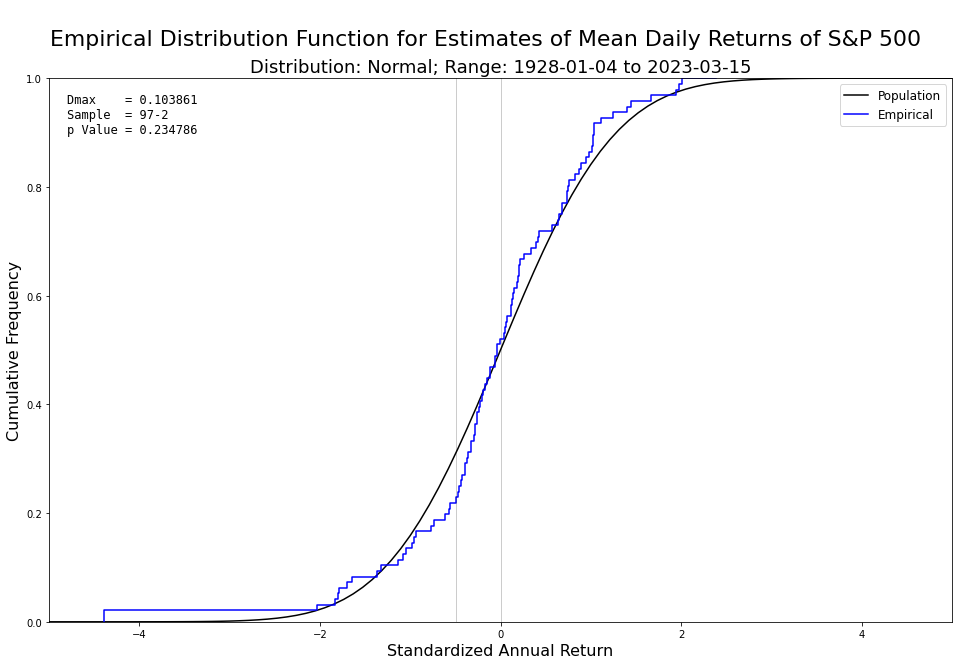

In [9]:
# Figure 2.13
from scipy.stats import norm,kstest
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
figure.suptitle("\nEmpirical Distribution Function for Estimates of Mean Daily Returns of S&P 500",fontsize=22)
plot.set_title("Distribution: Normal; Range: %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
x=np.linspace(-five,five,results.shape[0])
y=norm.cdf(x)
plot.plot(x,y,label='Population',color='black')
x=np.sort((results[('mu','value')]-results[('mu','value')].mean())/results[('mu','value')].std())
x=np.insert(x,0,min(x)) # extra point to complete the step plot
y=np.linspace(one/results.shape[0],one,results.shape[0])
y=np.insert(y,0,zero) # see above
plot.step(x,y,label='Empirical',color='blue')
ks=kstest(x[1:],'norm')
plot.axvline(ks.statistic_location,color='black',lw=1,alpha=0.2)
plot.text(-4.8,0.90,'Dmax    = %8.6f\nSample  = %d%+d\np Value = %8.6g' % (ks.statistic,len(x),-2,ks.pvalue),fontsize=12,fontdict={'family':'monospace'})
plot.axvline(zero,color='black',lw=1,alpha=0.2)
plot.set_ylabel("Cumulative Frequency",fontsize=16)
plot.set_xlabel("Standardized Annual Return",fontsize=16)
plot.set_xlim(-five,five)
plot.set_ylim(zero,one)
plot.legend(fontsize=12);

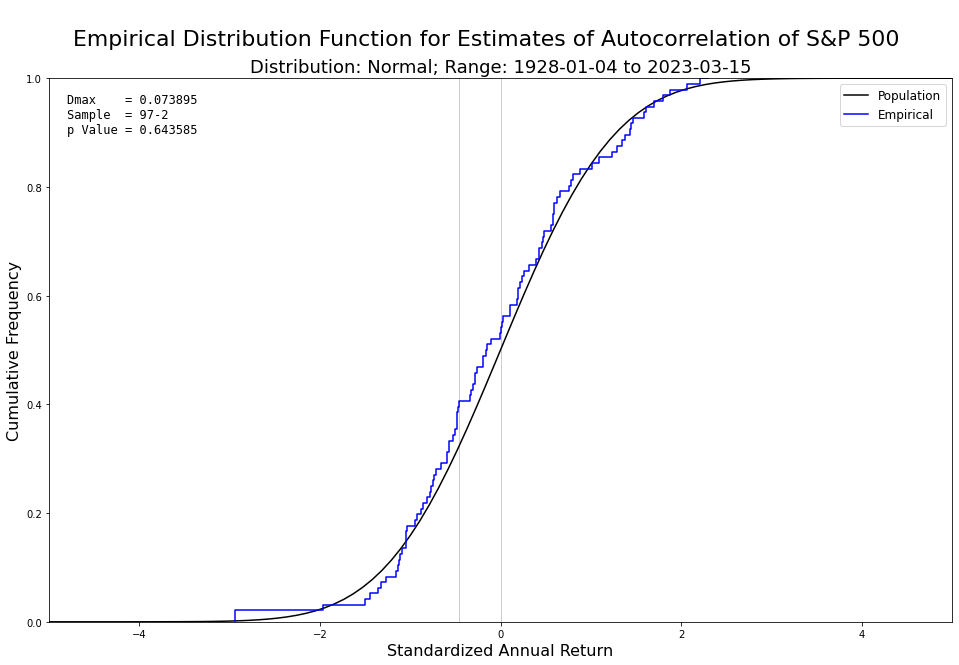

In [10]:
# Figure 2.14
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
figure.suptitle("\nEmpirical Distribution Function for Estimates of Autocorrelation of S&P 500",fontsize=22)
plot.set_title("Distribution: Normal; Range: %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
x=np.linspace(-five,five,results.shape[0])
y=norm.cdf(x)
plot.plot(x,y,label='Population',color='black')
x=np.sort((results[('phi','value')]-results[('phi','value')].mean())/results[('phi','value')].std())
x=np.insert(x,0,min(x)) # extra point to complete the step plot
y=np.linspace(one/results.shape[0],one,results.shape[0])
y=np.insert(y,0,zero) # see above
plot.step(x,y,label='Empirical',color='blue')
ks=kstest(x[1:],'norm')
plot.axvline(ks.statistic_location,color='black',lw=1,alpha=0.2)
plot.text(-4.8,0.90,'Dmax    = %8.6f\nSample  = %d%+d\np Value = %8.6g' % (ks.statistic,len(x),-2,ks.pvalue),fontsize=12,fontdict={'family':'monospace'})
plot.axvline(zero,color='black',lw=1,alpha=0.2)
plot.set_ylabel("Cumulative Frequency",fontsize=16)
plot.set_xlabel("Standardized Annual Return",fontsize=16)
plot.set_xlim(-five,five)
plot.set_ylim(zero,one)
plot.legend(fontsize=12);

In [34]:
# get the recessions data (NBER data at Fred) and perform ANOVA test onto estimates of mu
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"USREC","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('M')
USREC['year']=USREC.index.year
any=USREC.groupby('year').max().rename(columns={"USREC":("Recession","any")})
any.columns=pd.MultiIndex.from_tuples(any.columns)
results=results.merge(any,left_index=True,right_index=True)
avg=USREC.groupby('year').mean().rename(columns={"USREC":("Recession","mean")})
avg.columns=pd.MultiIndex.from_tuples(avg.columns)
results=results.merge(avg,left_index=True,right_index=True)
results[["mu","phi","Recession"]]

mu                                       phi            \
         value    stderr      tvalue    pvalue     value    stderr   
year                                                                 
1928  0.213503  0.083128    2.568357  0.010218  0.045765  0.082358   
1929  0.216307  0.002103  102.879108  0.000000 -0.053006  0.002125   
1930  0.112788  0.091795    1.228688  0.219189 -0.106637  0.063148   
1931 -0.326940  0.206822   -1.580782  0.113928 -0.132293  0.074194   
1932 -0.126060  0.202750   -0.621750  0.534106  0.023043  0.062912   
...        ...       ...         ...       ...       ...       ...   
2019  0.134205  0.041620    3.224513  0.001262 -0.054550  0.055471   
2020  0.251238  0.085197    2.948897  0.003189 -0.217395  0.097869   
2021  0.131092  0.040238    3.257891  0.001122 -0.022623  0.062843   
2022 -0.105474  0.099004   -1.065351  0.286717  0.024070  0.053859   
2023 -0.109302  0.002684  -40.719470  0.000000 -0.347771  0.002665   

                                Recession            
          tvalue         pvalue       any      mean  
year                                                 
1928    0.555688   5.784243e-01         0  0.000000  
1929  -24.948331  2.226293e-137         1  0.333333  
1930   -1.688678   9.128115e-02         1  1.000000  
1931   -1.783063   7.457610e-02         1  1.000000  
1932    0.366272   7.141617e-01         1  1.000000  
...          ...            ...       ...       ...  
2019   -0.983383   3.254188e-01         0  0.000000  
2020   -2.221290   2.633131e-02         1  0.166667  
2021   -0.359990   7.188543e-01         0  0.000000  
2022    0.446903   6.549450e-01         0  0.000000  
2023 -130.491621   0.000000e+00         0  0.000000  

[96 rows x 10 columns]

In [35]:
# perform ANOVA on annual average daily return
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
design=results[[('mu','value'),('Recession','any')]]
design.columns=['Returns','Recession']
lm=ols('Returns ~ Recession',design).fit()
anova_lm(lm).fillna("")

,df,sum_sq,mean_sq,F,PR(>F)
Recession,1.0,0.011534,0.011534,1.590497,0.210376
Residual,94.0,0.681664,0.007252,,


In [36]:
# perform ANOVA on autocorrelation of daily returns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
design=results[[('phi','value'),('Recession','any')]]
design.columns=['Autocorrelation','Recession']
lm=ols('Autocorrelation ~ Recession',design).fit()
anova_lm(lm).fillna("")

,df,sum_sq,mean_sq,F,PR(>F)
Recession,1.0,0.009478,0.009478,0.530468,0.468221
Residual,94.0,1.679515,0.017867,,


                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     10.11
Date:                Thu, 16 Mar 2023   Prob (F-statistic):            0.00199
Time:                        01:49:01   Log-Likelihood:                 105.37
No. Observations:                  96   AIC:                            -206.7
Df Residuals:                      94   BIC:                            -201.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0623      0.009      6.557      0.0

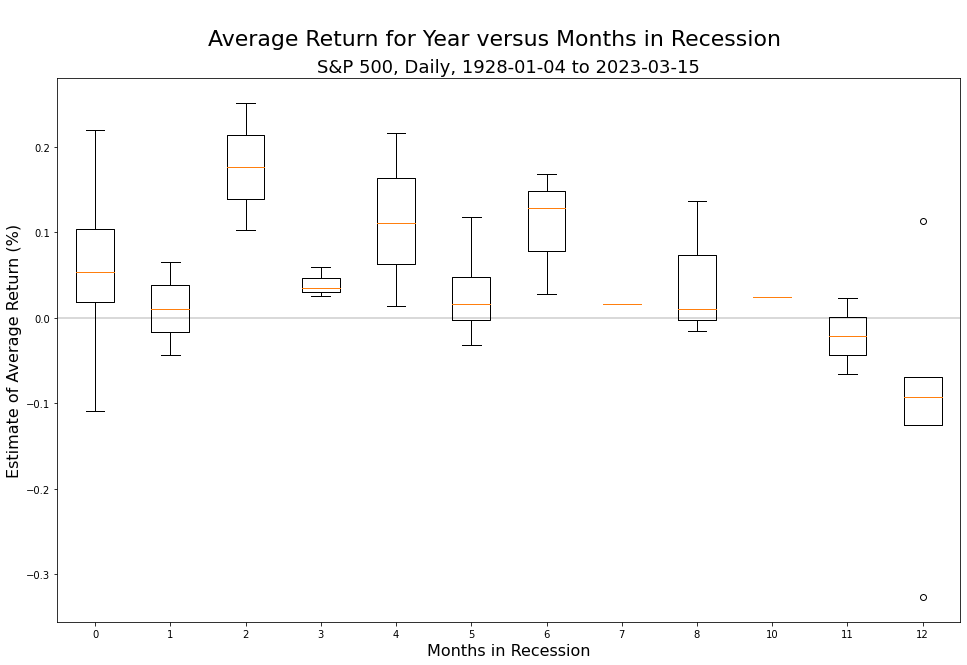

In [80]:
# bonus, regress mean daily return onto mean recession value
design=results[[('mu','value'),('Recession','mean')]]
design.columns=['Returns','Recession']
lm=ols('Returns ~ Recession',design).fit()
print(lm.summary())

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nAverage Return for Year versus Months in Recession",fontsize=22)
plot.set_title("S&P 500, Daily, %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
grouped=design.groupby("Recession")
plot.boxplot([grouped.get_group(x)["Returns"] for x in grouped.groups],labels=[str(int(12*k)) for k in grouped.groups])
plot.axhline(color='black',alpha=0.2)
plot.set_xlabel("Months in Recession",fontsize=16);
plot.set_ylabel("Estimate of Average Return (%)",fontsize=16);

                            OLS Regression Results                            
Dep. Variable:        Autocorrelation   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3424
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.560
Time:                        01:49:21   Log-Likelihood:                 57.887
No. Observations:                  96   AIC:                            -111.8
Df Residuals:                      94   BIC:                            -106.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0403      0.016      2.586      0.0

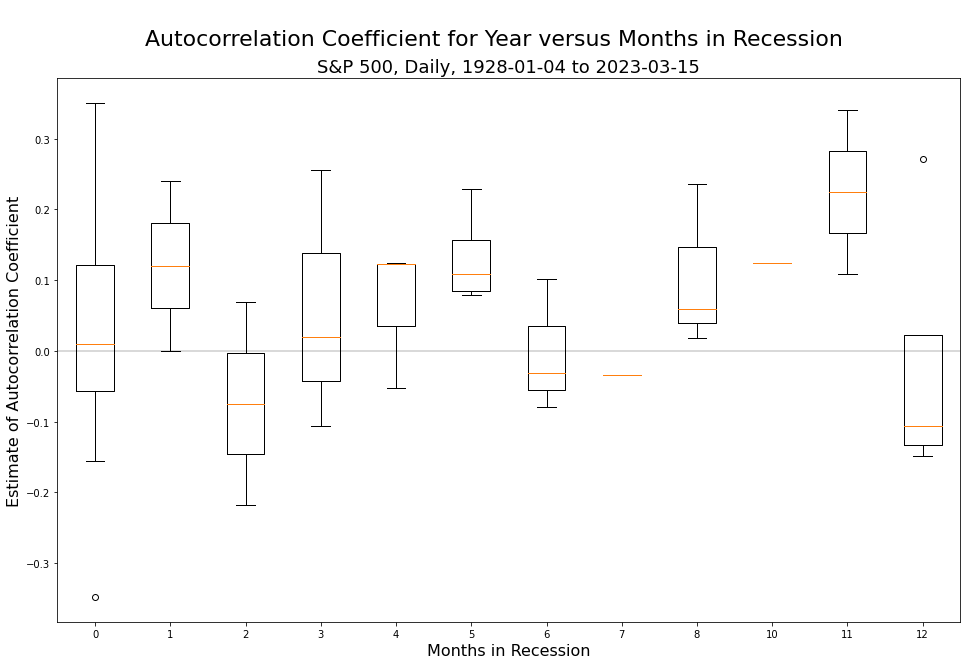

In [81]:
# bonus, regress autocorrelation coefficient onto mean recession value
design=results[[('phi','value'),('Recession','mean')]]
design.columns=['Autocorrelation','Recession']
lm=ols('Autocorrelation ~ Recession',design).fit()
print(lm.summary())

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nAutocorrelation Coefficient for Year versus Months in Recession",fontsize=22)
plot.set_title("S&P 500, Daily, %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
grouped=design.groupby("Recession")
plot.boxplot([grouped.get_group(x)["Autocorrelation"] for x in grouped.groups],labels=[str(int(12*k)) for k in grouped.groups])
plot.axhline(color='black',alpha=0.2)
plot.set_xlabel("Months in Recession",fontsize=16);
plot.set_ylabel("Estimate of Autocorrelation Coefficient",fontsize=16);